In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import numerics
import utils
import scipy.io as sio
import matlab_sindy_results
# reload module
import importlib
importlib.reload(matlab_sindy_results)

import os
import re
import pickle

# set cmap for this notebook
plt.rcParams['image.cmap'] = 'magma'

# load the data
def load_data(identifier_str):
    data = sio.loadmat(f'data/{identifier_str}.mat')
    U_data = torch.Tensor(data['U_data'])
    return U_data

ic = 'breather'
# ic = 'custom'

n_x = 100
n_t = 2000
x = torch.linspace(-10, 10, n_x)
t = torch.linspace(0, 10, n_t)
X, T = torch.meshgrid(x, t, indexing='ij')

U_true = utils.breather(X, T)
uv0 = utils.breather_ic(x)

# solve with FD to get test data
w_test = 2 * np.pi / 10 + 0.1
print(f'w_test^2: {w_test**2}, vs w^2: {(2 * np.pi / 10)**2}')
U_true_test = utils.breather(X, T, w_test)
uv0_test = utils.breather_ic(x, w = w_test)
# uv0_test = utils.custom_ic(x)
# U_true_test = numerics.solve_pde_2nd_in_time(uv0_test, x, t, utils.sine_gordon).T
ss_x = 5
ss_t = 80
# slices of X and T to get back to X_data and T_data
data_slices = [slice(None, None, ss_x), slice(None, None, ss_t)]

def choose_best_dhpm(identifier_str):
    U_data = load_data(identifier_str)

    # get all the .pkl files in the directory 'models/' + identifier_str, import then
    model_dir = 'models/' + identifier_str
    models = []

    for file in os.listdir(model_dir):
        if file.endswith('.pkl'):
            with open(model_dir + '/' + file, 'rb') as f:
                models.append(pickle.load(f))

    print(f'Loaded {len(models)} models')

    # compute validation error by solving the PDE with uv0, and compare to U_data
    val_errors = np.zeros(len(models))
    for i, model in enumerate(models):
        with torch.no_grad():
            U_pde_pred = numerics.solve_pde_2nd_in_time(uv0, x, t, model.N_dnn).T
            U_pde_pred_data = U_pde_pred[data_slices]
            val_error = utils.l2_error(U_data, U_pde_pred_data)
        val_errors[i] = val_error

    print(val_errors)
    model = models[np.argmin(val_errors)]
    return model


def choose_best_sindy(identifier_str):
    U_data = load_data(identifier_str)
    ms = [3,4]

    sindy_val_errors = np.ones(len(ms)) * np.inf
    for i, m in enumerate(ms):
        N_sindy = matlab_sindy_results.get_wsindy_model(identifier_str, m = m)
        if N_sindy is None:
            continue

        with torch.no_grad():
            U_pde_pred = numerics.solve_pde_2nd_in_time(uv0, x, t, N_sindy).T
            U_pde_pred_data = U_pde_pred[data_slices]
            val_error = utils.l2_error(U_data, U_pde_pred_data)
        sindy_val_errors[i] = val_error

    print(sindy_val_errors)
    m = ms[np.nanargmin(sindy_val_errors)]
    N_sindy = matlab_sindy_results.get_wsindy_model(identifier_str, m = m)
    print(f'Selected m = {m}, error: {sindy_val_errors[np.nanargmin(sindy_val_errors)]}')

    return N_sindy


torch.manual_seed(0)

noise_levels = [0.0, 0.05, 0.2, 0.5]
l2s = np.zeros((len(noise_levels), 4))

for j, noise_level in enumerate(noise_levels):
    identifier_str = f'ssx{ss_x}_sst{ss_t}_nl{noise_level}_nx{n_x}_nt{n_t}_{ic}'

    model = choose_best_dhpm(identifier_str)
    N_sindy = choose_best_sindy(identifier_str)

    # now, evaluate this model on the true data and the test data
    with torch.no_grad():
        U_pred = numerics.solve_pde_2nd_in_time(uv0, x, t, model.N_dnn).T
        U_pred_test = numerics.solve_pde_2nd_in_time(uv0_test, x, t, model.N_dnn).T
        l2 = utils.l2_error(U_true, U_pred)
        l2_test = utils.l2_error(U_true_test, U_pred_test)

        U_pred_sindy = numerics.solve_pde_2nd_in_time(uv0, x, t, N_sindy).T
        U_pred_test_sindy = numerics.solve_pde_2nd_in_time(uv0_test, x, t, N_sindy).T
        l2_sindy = utils.l2_error(U_true, U_pred_sindy)
        l2_test_sindy = utils.l2_error(U_true_test, U_pred_test_sindy)

    print(f'L2 error on true data: {l2}')
    print(f'L2 error on test data: {l2_test}')

    print(f'L2 error on true data (SINDy): {l2_sindy}')
    print(f'L2 error on test data (SINDy): {l2_test_sindy}')

    l2s[j] = [l2, l2_test, l2_sindy, l2_test_sindy]

w_test^2: 0.530447882187166, vs w^2: 0.3947841760435743
Loaded 10 models
[1.59216714 0.63289541 0.69116527 0.13812438 0.12088381 0.10868075
 0.09328456 0.08442398 0.07329129 0.08668467]
[       nan 0.04470038]
Selected m = 4, error: 0.04470038414001465
L2 error on true data: 0.07345236837863922
L2 error on test data: 0.16364029049873352
L2 error on true data (SINDy): 0.04501934349536896
L2 error on test data (SINDy): 0.17545920610427856
Loaded 10 models
[2.03374004 0.56996477 0.21729752 0.16842642 0.14468636 0.13112999
 0.11916709 0.11682542 0.06279907 0.07123398]
[0.58409005 0.11085714]
Selected m = 4, error: 0.11085713654756546
L2 error on true data: 0.036937836557626724
L2 error on test data: 0.09534119814634323
L2 error on true data (SINDy): 0.09637654572725296
L2 error on test data (SINDy): 0.1830224245786667
Loaded 10 models
[2.54871321 1.15977502 0.24981526 0.33840421 0.29120108 0.26336151
 0.25774223 0.23858495 0.23780291 0.23576041]
[0.47797912        nan]
Selected m = 3, erro

(0.0, 1.0)

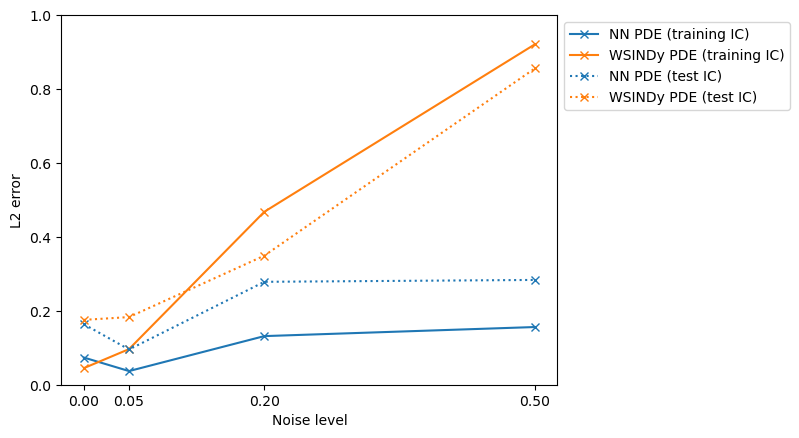

In [11]:
plt.figure()
plt.plot(noise_levels, l2s[:, 0], marker='x', label='NN PDE (training IC)')
plt.plot(noise_levels, l2s[:, 2], marker='x', label='WSINDy PDE (training IC)')
plt.plot(noise_levels, l2s[:, 1], color='C0', linestyle=':', marker='x', label='NN PDE (test IC)')
plt.plot(noise_levels, l2s[:, 3], color='C1', linestyle=':', marker='x', label='WSINDy PDE (test IC)')

plt.xlabel('Noise level')
plt.ylabel('L2 error')
# put outside of figure, to right
plt.legend(loc = 'upper left', bbox_to_anchor = (1.0, 1.0))
# change x ticks to show the noise levels
plt.xticks(noise_levels)
plt.ylim([0, 1.0])